In [1]:
from openbb import obb
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append(r'C:\Users\avido\Documents\other code\AlgoTrading')
from utils import local_data_interface as ldi
from assets.api_credentials import openbb_pat
obb.account.login(pat=openbb_pat, remember_me=True)

import indicators as inds
from indicators import custom_indicators as ci
from indicators import pandas_ta_indicators as pti
from indicators import tulipy_indicators as ti
from indicators import sets
from indicators import metaindicators as mi
from utils import ohlc_utils as ou

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [12, 4]

In [2]:
df = ldi.get_ticker(symbol='GOOG', start_date="1980-01-01", end_date='2025-03-10', interval='1d')

df.fillna(method='ffill', inplace=True)
print(len(df))
df.head()

5172


C:\Users\avido\AppData\Local\Temp\ipykernel_44204\1976176805.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


,open,high,low,close,volume,vwap,adj_close,unadjusted_volume,change,change_percent
date,,,,,,,,,,
2004-08-19,2.49,2.59,2.39,2.50,897427216,2.49,2.49,897427216.0,0.008469,0.003400
2004-08-20,2.52,2.72,2.50,2.70,458857488,2.61,2.69,458857488.0,0.181820,0.072300
2004-08-23,2.76,2.83,2.72,2.72,366857939,2.76,2.72,366857939.0,-0.033624,-0.012200
2004-08-24,2.77,2.78,2.58,2.61,306396159,2.69,2.60,306396159.0,-0.158660,-0.057300
2004-08-25,2.61,2.69,2.59,2.64,184645512,2.63,2.63,184645512.0,0.025903,0.009909


In [6]:
set = [
    ci.EMA(period=14, key='close'),
    mi.EMA(ci.ticker(key='close'), period=14),
]

extractor = inds.Extractor(set) #sets.z_score_close_volume) #sets.sma_ratios) #sets.all_custom_indicators) #sets.all_tulipy_defaults) #sets.all_candlestick_patterns)
new_df = extractor.extract(df)
new_df.head()

,"EMA(period=14,key=close)","EMA(ind=ticker(key=close),period=14)"
date,,
2004-08-19,2.500000,2.500000
2004-08-20,2.526667,2.607143
2004-08-23,2.552444,2.650255
2004-08-24,2.560119,2.637940
2004-08-25,2.570769,2.638477


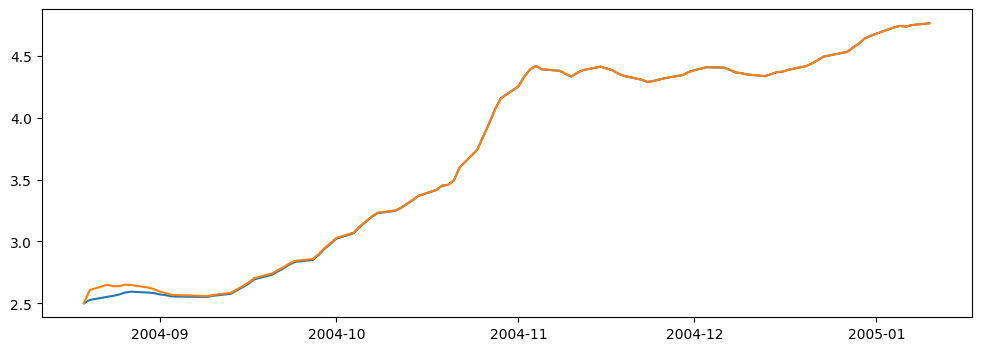

In [13]:
start = 0
stop = 100
for c in new_df.columns:
    if c == 'date':
        continue
    plt.plot(new_df[c][start:stop], label=c)

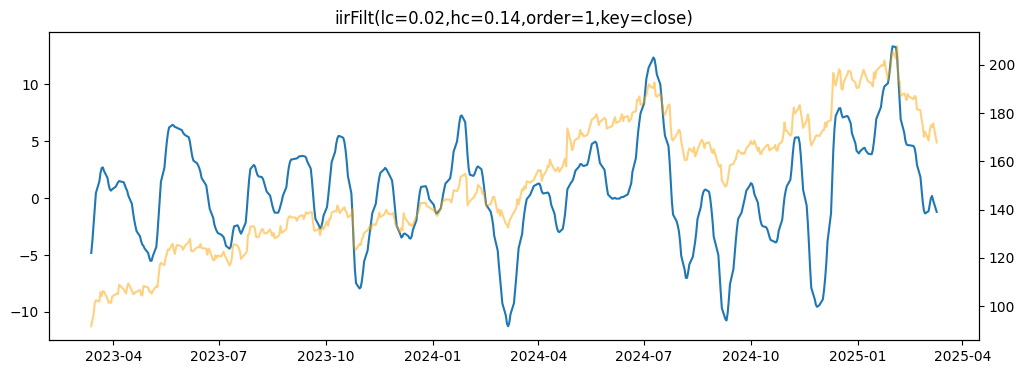

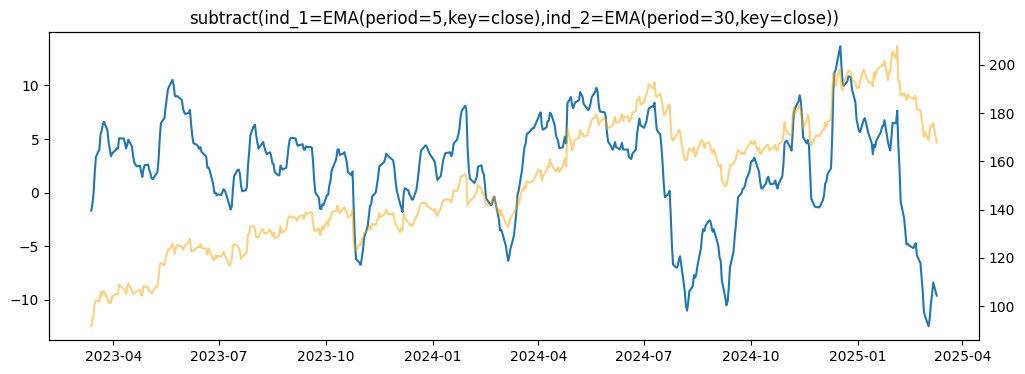

In [94]:
num_samples = 500

for key in new_df.columns:
    plt.plot(new_df[key][-num_samples:], label=key)
    # on a spearate yaxis plot close price.
    ax2 = plt.gca().twinx()
    ax2.plot(df['close'][-num_samples:], label='close', color='orange', alpha=0.5)
    plt.title(key)
    plt.show()

In [115]:
max_corr = 0
best_i = 0
best_j = 0
for i in range(1, 99):
    for j in range(1, 99):
        if j <= i:
            continue
        set = [
            ci.iirFilt(lc = .02, hc = .8, order=1),
            mi.subtract(ci.EMA(i),ci.EMA(j))
        ]
        extractor = inds.Extractor(set) #sets.z_score_close_volume) #sets.sma_ratios) #sets.all_custom_indicators) #sets.all_tulipy_defaults) #sets.all_candlestick_patterns)
        new_df = extractor.extract(df)
        corr = new_df.corr().values[0, 1]
        if corr > max_corr:
            max_corr = corr
            best_i = i
            best_j = j

In [100]:
min_diff = 99999
best_i = 0
best_j = 0
for i in range(1, 99):
    for j in range(1, 99):
        if j <= i:
            continue
        set = [
            ci.iirFilt(lc = i/100, hc = j/100, order=1),
            mi.subtract(ci.EMA(5),ci.EMA(50))
        ]
        extractor = inds.Extractor(set) #sets.z_score_close_volume) #sets.sma_ratios) #sets.all_custom_indicators) #sets.all_tulipy_defaults) #sets.all_candlestick_patterns)
        new_df = extractor.extract(df)
        diff = np.sum(np.abs(new_df[new_df.columns[0]].values - new_df[new_df.columns[1]].values))
        if diff < min_diff:
            min_diff = diff
            best_i = i
            best_j = j

In [109]:
min_diff

8100.025494142237

In [110]:
best_i, best_j

(2, 3)

In [91]:
max_corr

0.7306653451820584

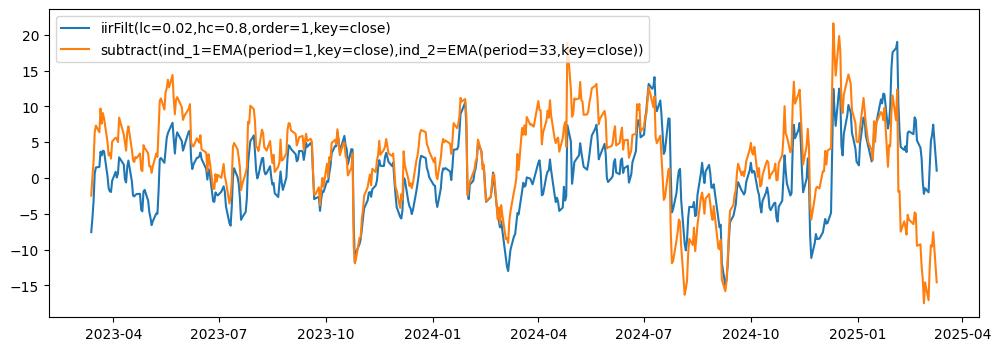

In [116]:
set = [
    ci.iirFilt(lc = .02, hc = .8, order=1),
    mi.subtract(ci.EMA(best_i),ci.EMA(best_j))
]

extractor = inds.Extractor(set) #sets.z_score_close_volume) #sets.sma_ratios) #sets.all_custom_indicators) #sets.all_tulipy_defaults) #sets.all_candlestick_patterns)
new_df = extractor.extract(df)

for key in new_df.columns:
    plt.plot(new_df[key][-num_samples:], label=key)
    # on a spearate yaxis plot close price.
plt.legend(loc='upper left')
plt.show()

In [14]:
non_stationary_cols = ou.detect_nonstationary_columns(new_df, threshold=0.05)
non_stationary_cols

In [10]:
# nan % per column
new_df.isna().sum() / len(new_df) * 100

adosc(short=3,long=10)                                                                                           0.0
adx(period=14)                                                                                                   0.0
adxr(period=14)                                                                                                  0.0
ao()                                                                                                             0.0
apo(short=12,long=26)                                                                                            0.0
aroon_up(period=14)_up                                                                                           0.0
aroon_down(period=14)_down                                                                                       0.0
aroonosc(period=14)                                                                                              0.0
bop()                                                           

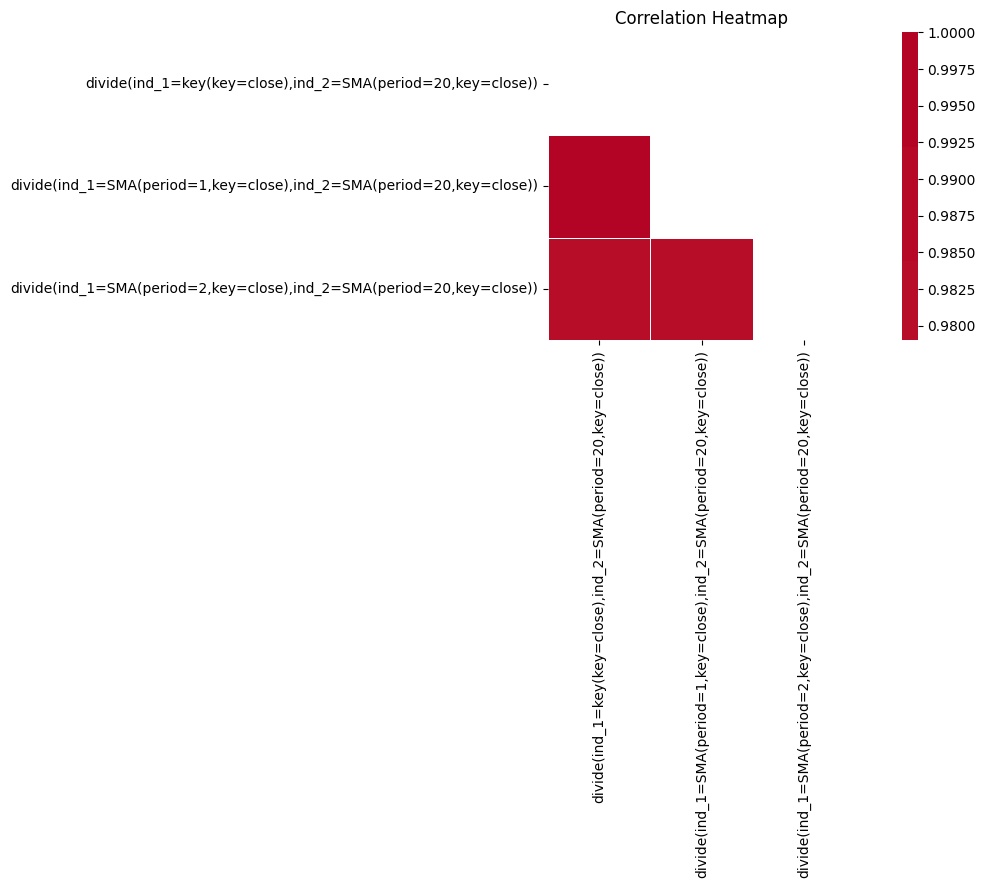

In [11]:
# plot correlation heatmap 
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np

corr = new_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, annot=False, square=True, linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()


In [9]:
non_stationary_cols

['atr(period=14)',
 'dm_plus(period=14)_plus',
 'dm_minus(period=14)_minus',
 'tr()']

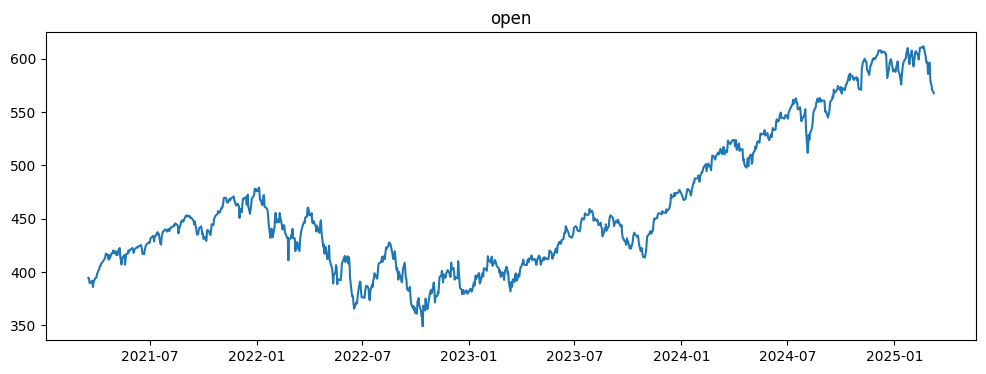

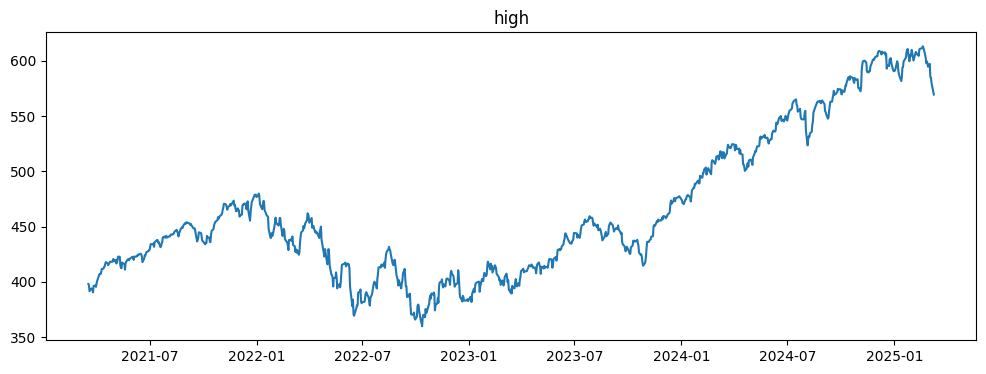

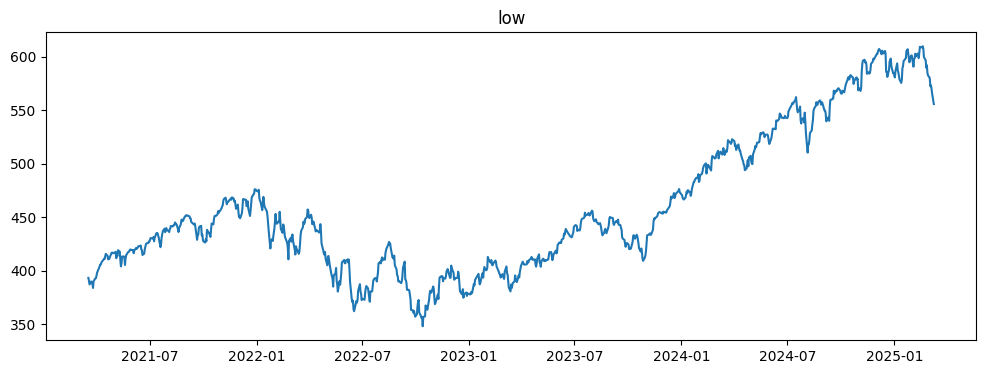

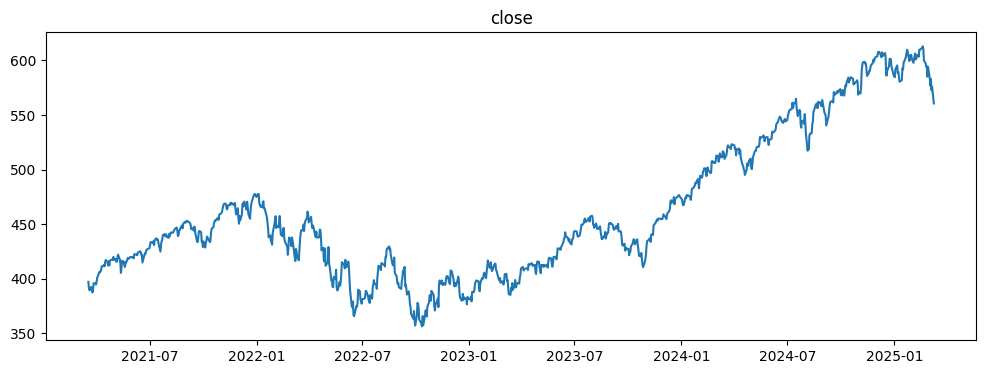

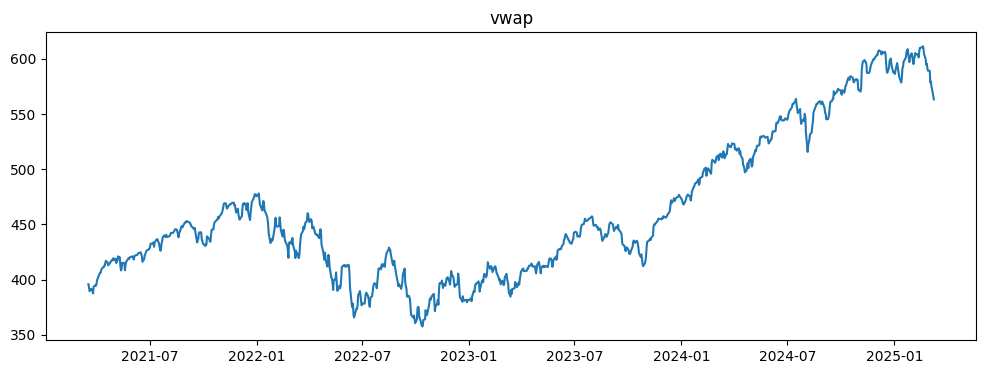

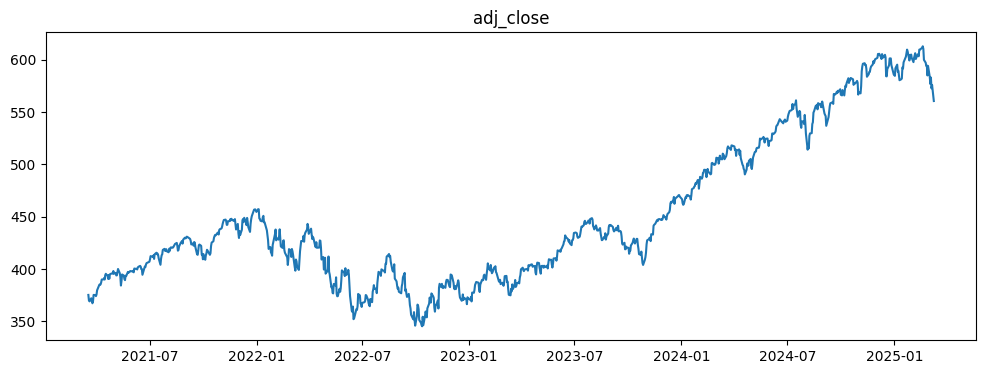

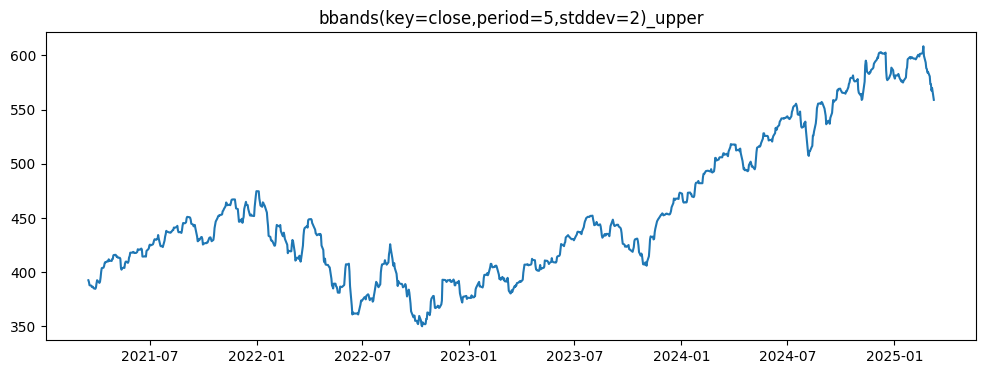

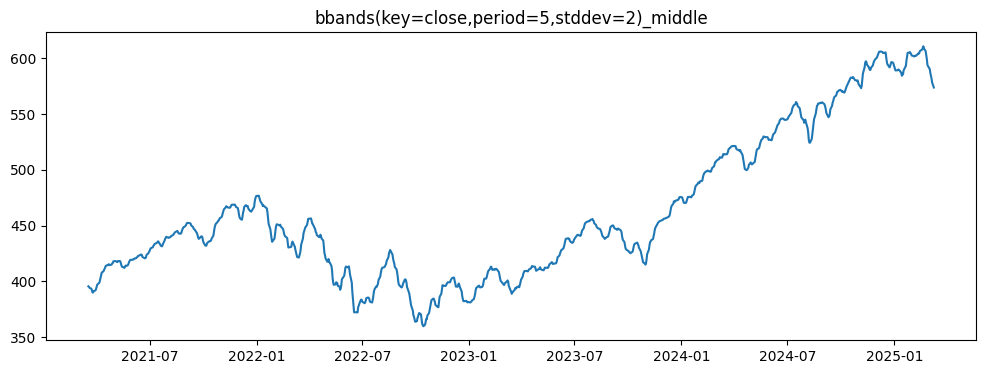

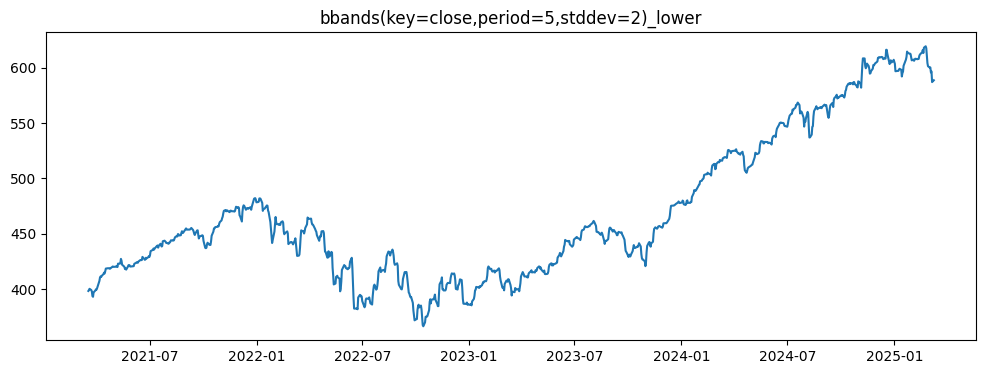

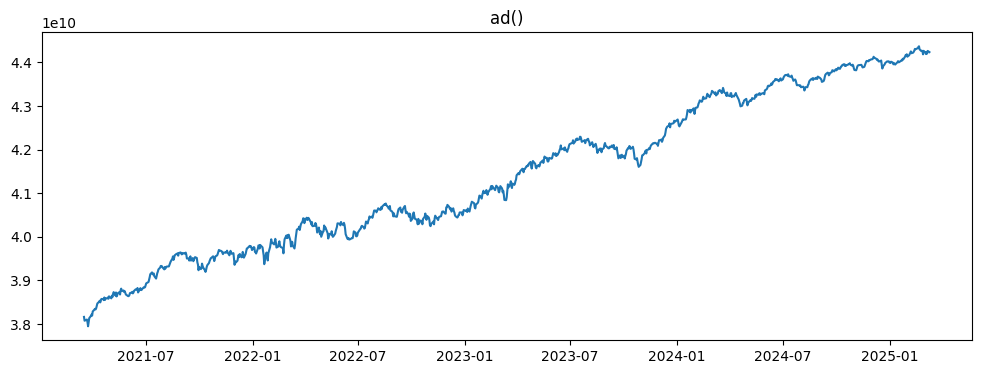

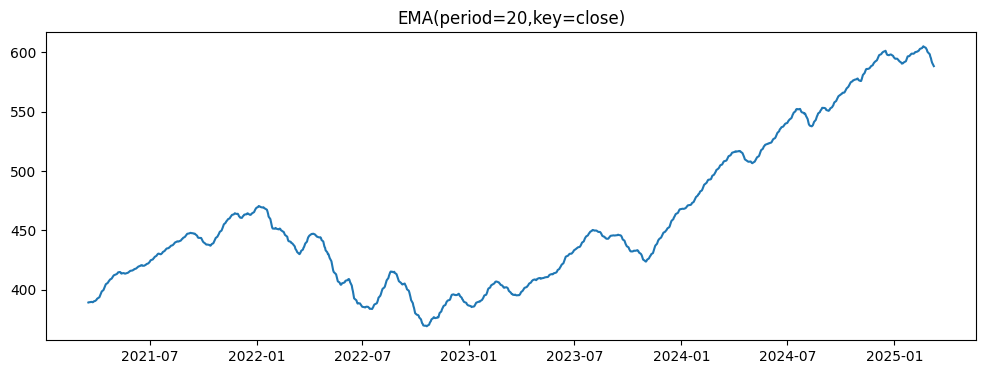

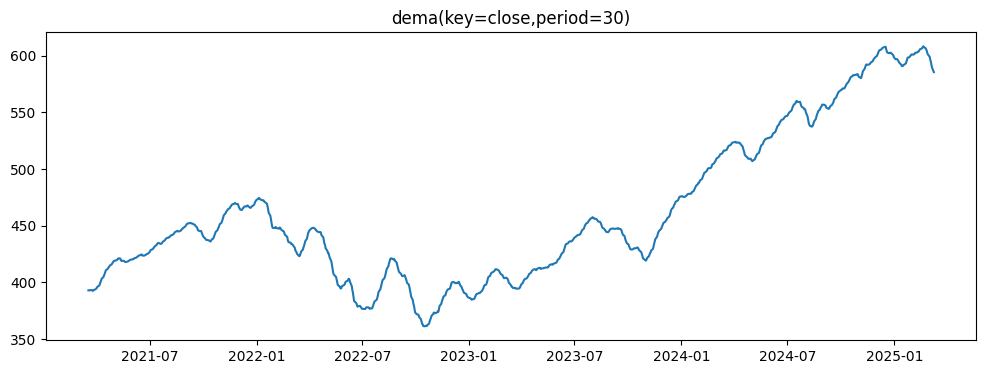

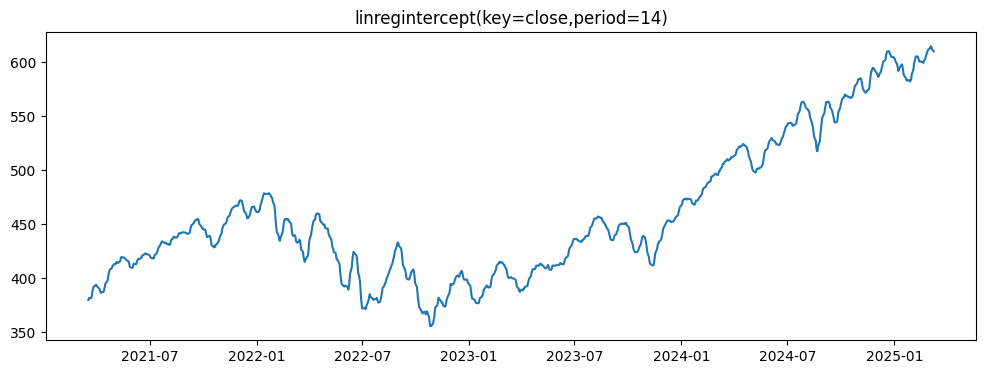

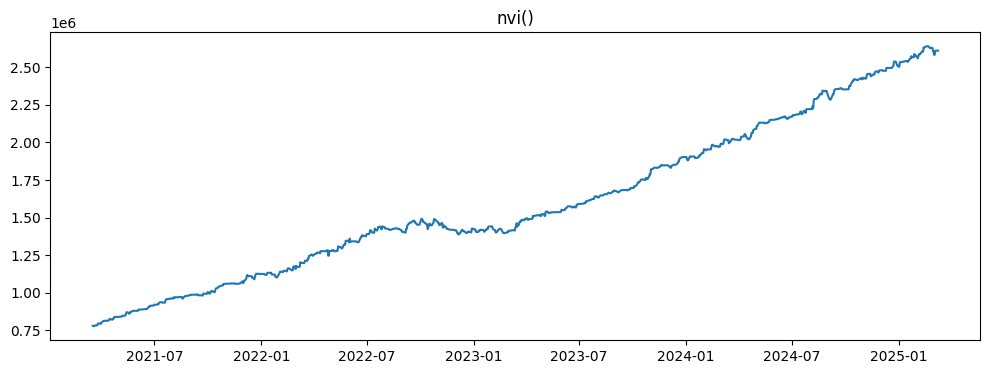

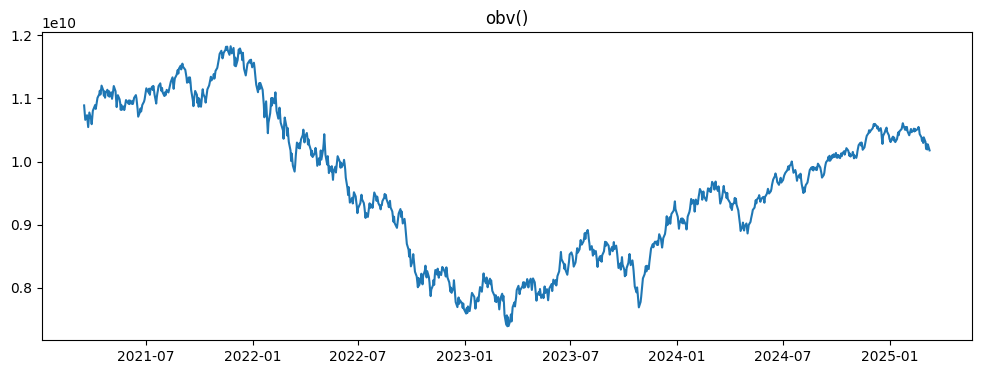

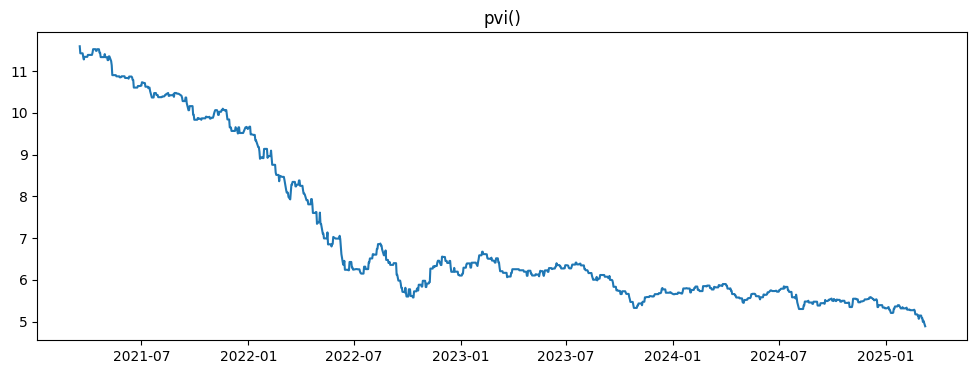

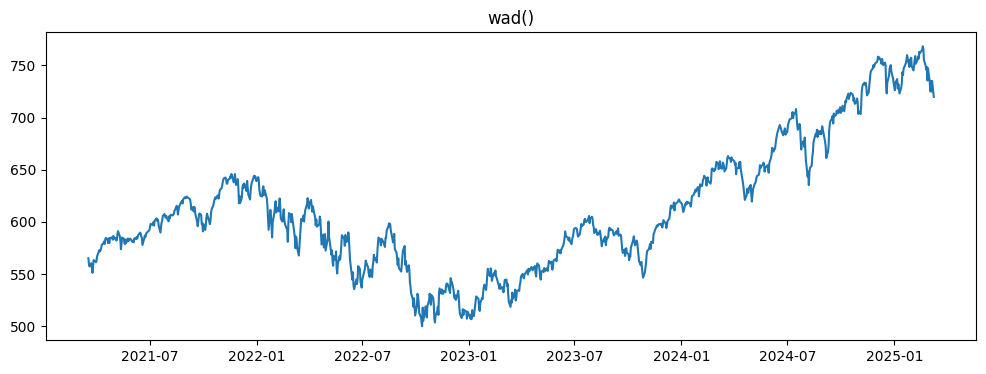

In [43]:
for col in non_stationary_cols:
    plt.plot(new_df[col][-num_samples:], label=col)
    plt.title(col)
    plt.show()

In [44]:
non_stationary_cols

['open',
 'high',
 'low',
 'close',
 'vwap',
 'adj_close',
 'bbands(key=close,period=5,stddev=2)_upper',
 'bbands(key=close,period=5,stddev=2)_middle',
 'bbands(key=close,period=5,stddev=2)_lower',
 'ad()',
 'EMA(period=20,key=close)',
 'dema(key=close,period=30)',
 'linregintercept(key=close,period=14)',
 'nvi()',
 'obv()',
 'pvi()',
 'wad()']